In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
from pycbc.filter import sigmasq
from calcwf import chirp2total, gen_wf, shifted_e_approx, shifted_e, ceiltwo, gen_psd

Only loading in here, still need to add generating code (and therefore rerun with 'correct' shifted_e and any other code changes). Of course also need to figure out what we want to use for degeneracy line equation as well! At the moment still using old -14/3 version with shifted_e_approx(), which is obviously not ideal.

In [2]:
# Differentiates square of shifted e eqn using np.gradient()
def diff_shifted_e2(f_0, e_0, n=5, df=0.1, order=2):

    # Ensure e_0 is array
    e_0s = np.array(e_0).flatten()

    # Setup differentiation
    assert n%2 == 1
    f_arr = np.linspace(f_0 - int(n/2)*df, f_0 + int(n/2)*df, n)
    diff_arrs = np.empty((order+1, len(e_0s), n))

    # Calculate for each eccentricity
    for i, e_0 in enumerate(e_0s):
        e_arr = shifted_e(f_arr, f_0, e_0)**2
        diff_arrs[0][i] = e_arr
    
        # Perform differentiation
        for j in range(order):
            diff_arrs[j+1][i] = np.gradient(diff_arrs[j][i], df)

    # Evaluate at f_0
    return diff_arrs[1:,:,int(n/2)]

def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/14)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e_approx(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e_approx(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

def favata_et_al_exact(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-5/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-5/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/10)
    print('Average frequency: '+str(avg_f)+' Hz')
    s_given_e = shifted_e(avg_f, f_low, given_e)
    print(f'Given_e shifted from {given_e} to {s_given_e}')
    s_e_vals = shifted_e(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    s_given_e2_d, s_given_e2_d2 = diff_shifted_e2(avg_f, s_given_e)
    eff_chirp = given_chirp/(1 - (2355/1462)*s_given_e**2
                             + (7065/5848)*avg_f*s_given_e2_d 
                             - (4239/11696)*avg_f**2*s_given_e2_d2)**(3/5)

    # Convert to chirp mass values
    s_e_vals2_d, s_e_vals2_d2 = diff_shifted_e2(avg_f, s_e_vals)
    chirp_vals = eff_chirp*(1 - (2355/1462)*s_e_vals**2
                            + (7065/5848)*avg_f*s_e_vals2_d 
                            - (4239/11696)*avg_f**2*s_e_vals2_d2)**(3/5)

    return chirp_vals

Load in and make e^2 against chirp plot here:

Average frequency: 31.815554956702417 Hz
Given_e shifted from 0 to 0.0
Average frequency: 31.815554956702417 Hz
Given_e shifted from 0 to 0.0


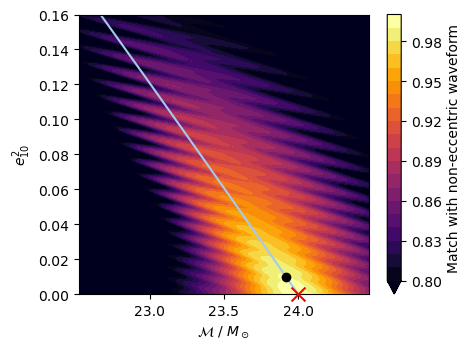

In [4]:
# Load data
with open(os.path.join('..', 'EccentricBinaries', 'notebooks', 'e_sqrd_chirp_data_v2', 'dataslot_2', 'all_matches'), 'rb') as fp:
        data = pickle.load(fp)[0][24]

# Axes
e_vals = data['e_vals'][data['e_vals']<=0.4]
chirp_vals = data['chirp_vals'][np.logical_and(data['chirp_vals']>=22.5, data['chirp_vals']<=24.5)]

# Make plot
plt.figure(figsize=(0.75*6.4,0.75*4.8))
cmap = mpl.colormaps['inferno']
colours = list(cmap(np.linspace(0, 1, 21)))[1:]
colours.insert(0, '#00001E')
cs = plt.contourf(chirp_vals, e_vals**2, data['teob_match'][data['e_vals']<=0.4][:,np.logical_and(data['chirp_vals']>=22.5, data['chirp_vals']<=24.5)],
                  np.linspace(0.8, 1, 21), vmin=0.8, vmax=1, extend='min', colors=colours)
for c in cs.collections:
    c.set_rasterized(True)
plt.colorbar(label='Match with non-eccentric waveform')
plt.scatter(favata_et_al_avg(0, 24, 0.1), 0.1**2, c='k', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.plot(favata_et_al_avg(0, 24, e_vals), e_vals**2, c='#A6CAEC', label='Empirical')
# plt.plot(favata_et_al_exact(0.1, 24, e_vals), e_vals**2, c='k', label='Analytical')
plt.scatter(24, 0, c='r', zorder=10, clip_on=False, marker='x', s=100)
plt.ylim(ylims)
plt.xlim(xlims)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e_{10}^2$')
# plt.legend(loc='lower left', bbox_to_anchor=(0,0), fancybox=False, framealpha=1, borderaxespad=0, edgecolor='k')
plt.tight_layout()
plt.savefig('Figures/e_sqrd_chirp.png', dpi=450)